# Project on Bike Rental Count

Using these Bike Sharing systems, people rent a bike from one location and return it to a different or same place on need basis. People can rent a bike through membership (mostly regular users) or on demand basis (mostly casual users). This process is controlled by a network of automated kiosk across the city.
Bike sharing systems are a means of renting bicycles where the process of
obtaining membership, rental, and bike return is automated via a network of
kiosk locations throughout a city.Currently, there are over 500 bike-sharing programs
around the world.
The data generated by these systems makes them attractive for
researchers because the duration of travel, departure location, arrival
location, and time elapsed is explicitly recorded. Bike sharing systems
therefore function as a sensor network, which can be used for studying
mobility in a city.

Data
You are provided with following files:
1. train.csv : Use this dataset to train the model. This file contains all the
weather related features as well as the target variable “count”. Train
dataset is comprised of first 18 months.
2. test.csv : Use the trained model to predict the count of total rentals for
each hour during the next 6 months.

1. We will first explore the dataset provided
2. We will create models to predict the hourly bike rental demand. 
3. We will also make predictions for hourly demand in the test set which you can submit in the solution_checker.xlsx file to generate rmsle score. 


# Problem Statement-
In this project, we are asked to combine historical usage patterns with
weather data in order to forecast hourly bike rental demand.

In [86]:
# importing libraries
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os

In [87]:
# loadind the data
train = pd.read_csv('train_project2.csv')
test = pd.read_csv('test_project2.csv')

In [54]:
# shape of training and testing data
train.shape,test.shape

((13003, 16), (4376, 16))

In [55]:
train.describe()

,temp,atemp,humidity,windspeed,casual,registered,count
count,13003.000000,13003.000000,13003.000000,13003.000000,13003.000000,13003.000000,13003.000000
mean,19.746405,23.132787,62.352380,13.137588,32.495962,135.217488,167.713451
std,7.840164,8.560571,19.977424,8.322813,46.659489,131.901852,160.785488
min,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.120000,15.910000,47.000000,7.001500,3.000000,30.000000,35.000000
50%,19.680000,23.485000,62.000000,12.998000,14.000000,103.000000,124.000000
75%,26.240000,30.305000,79.000000,19.001200,42.000000,194.000000,246.000000
max,40.180000,50.000000,100.000000,56.996900,367.000000,796.000000,957.000000


In [56]:
test.describe()

,temp,atemp,humidity,windspeed,casual,registered,count
count,4376.000000,4376.00000,4376.000000,4376.000000,0.0,0.0,0.0
mean,22.248684,25.73792,63.823812,11.544852,NaN,NaN,NaN
std,7.759591,8.39031,17.053001,7.688794,NaN,NaN,NaN
min,5.740000,7.57500,16.000000,0.000000,NaN,NaN,NaN
25%,14.760000,18.18000,50.000000,7.001500,NaN,NaN,NaN
50%,22.960000,26.51500,65.000000,11.001400,NaN,NaN,NaN
75%,28.700000,32.57500,78.000000,16.997900,NaN,NaN,NaN
max,41.000000,45.45500,100.000000,43.998900,NaN,NaN,NaN


There are 12 columns in train dataset, whereas 09 in the test dataset. The missing column in the test dataset is the target variable and we will train our model to predict that variable.

In [57]:
# printing first five rows
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,DOW,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,5,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,5,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,5,4


In [58]:
train.tail(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,DOW,hour
12998,2012-06-30 19:00:00,3,0,0,1,34.44,37.880,44,16.9979,134,240,374,2012,6,5,19
12999,2012-06-30 20:00:00,3,0,0,1,33.62,38.635,52,11.0014,88,204,292,2012,6,5,20
13000,2012-06-30 21:00:00,3,0,0,1,33.62,38.635,52,11.0014,48,165,213,2012,6,5,21
13001,2012-06-30 22:00:00,3,0,0,1,31.98,37.120,62,11.0014,38,134,172,2012,6,5,22
13002,2012-06-30 23:00:00,3,0,0,1,31.98,37.120,62,6.0032,33,119,152,2012,6,5,23


In [59]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,DOW,hour
0,2012-07-01 00:00:00,3,0,0,1,31.16,36.365,66,0.0000,NaN,NaN,NaN,2012,7,6,0
1,2012-07-01 01:00:00,3,0,0,1,30.34,34.850,70,8.9981,NaN,NaN,NaN,2012,7,6,1
2,2012-07-01 02:00:00,3,0,0,1,29.52,34.850,74,6.0032,NaN,NaN,NaN,2012,7,6,2
3,2012-07-01 03:00:00,3,0,0,1,29.52,35.605,84,8.9981,NaN,NaN,NaN,2012,7,6,3
4,2012-07-01 04:00:00,3,0,0,1,28.70,33.335,79,12.9980,NaN,NaN,NaN,2012,7,6,4


In [60]:
test.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,DOW,hour
4371,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,2012,12,0,19
4372,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,2012,12,0,20
4373,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN,2012,12,0,21
4374,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN,2012,12,0,22
4375,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,NaN,NaN,NaN,2012,12,0,23


In [61]:
# columns in the dataset
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'DOW', 'hour'],
      dtype='object')

In [62]:
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'DOW', 'hour'],
      dtype='object')

We can infer that "count" is our target variable as it is missing from the test dataset.

In [63]:
# Data type of the columns
train.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
year                category
month               category
DOW                 category
hour                category
dtype: object

In [64]:
test.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual               float64
registered           float64
count                float64
year                category
month               category
DOW                 category
hour                category
dtype: object

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13003 entries, 0 to 13002
Data columns (total 16 columns):
datetime      13003 non-null datetime64[ns]
season        13003 non-null category
holiday       13003 non-null category
workingday    13003 non-null category
weather       13003 non-null category
temp          13003 non-null float64
atemp         13003 non-null float64
humidity      13003 non-null int64
windspeed     13003 non-null float64
casual        13003 non-null int64
registered    13003 non-null int64
count         13003 non-null int64
year          13003 non-null category
month         13003 non-null category
DOW           13003 non-null category
hour          13003 non-null category
dtypes: category(8), datetime64[ns](1), float64(3), int64(4)
memory usage: 916.6 KB


In [66]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4376 entries, 0 to 4375
Data columns (total 16 columns):
datetime      4376 non-null datetime64[ns]
season        4376 non-null category
holiday       4376 non-null category
workingday    4376 non-null category
weather       4376 non-null category
temp          4376 non-null float64
atemp         4376 non-null float64
humidity      4376 non-null int64
windspeed     4376 non-null float64
casual        0 non-null float64
registered    0 non-null float64
count         0 non-null float64
year          4376 non-null category
month         4376 non-null category
DOW           4376 non-null category
hour          4376 non-null category
dtypes: category(8), datetime64[ns](1), float64(6), int64(1)
memory usage: 309.7 KB


We can infer that all of the variable in the dataset except datetime are numerical variables. Now Let's look at the distribution of our target variable, i.e. count. As it is a numerical variable, let us look at its distribution.

In [40]:
test["casual"]=np.nan
test["registered"]=np.nan
test["count"]=np.nan


In [41]:
#feature engg.
test['datetime']=pd.to_datetime(test['datetime'])
train['datetime']=pd.to_datetime(train['datetime'])

In [42]:
train['year']=train['datetime'].dt.year
train['month']=train['datetime'].dt.month
train['DOW']=train['datetime'].dt.dayofweek
train['hour']=train['datetime'].dt.hour
test['year']=test['datetime'].dt.year
test['month']=test['datetime'].dt.month
test['DOW']=test['datetime'].dt.dayofweek
test['hour']=test['datetime'].dt.hour


In [43]:
train['season']=train.season.astype('category')
train['holiday']=train.holiday.astype('category')
train['workingday']=train.workingday.astype('category')
train['weather']=train.weather.astype('category')
train['year']=train.year.astype('category')
train['month']=train.month.astype('category')
train['DOW']=train.DOW.astype('category')
train['hour']=train.hour.astype('category')
test['season']=test.season.astype('category')
test['holiday']=test.holiday.astype('category')
test['workingday']=test.workingday.astype('category')
test['weather']=test.weather.astype('category')
test['year']=test.year.astype('category')
test['month']=test.month.astype('category')
test['DOW']=test.DOW.astype('category')
test['hour']=test.hour.astype('category')

In [44]:
# missing value treatment
train.isnull()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,DOW,hour
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12998,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12999,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
13000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
13001,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [45]:
test.isnull()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,DOW,hour
0,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4371,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False
4372,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False
4373,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False
4374,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False


In [46]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
DOW           0
hour          0
dtype: int64

In [47]:
test.isnull().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual        4376
registered    4376
count         4376
year             0
month            0
DOW              0
hour             0
dtype: int64

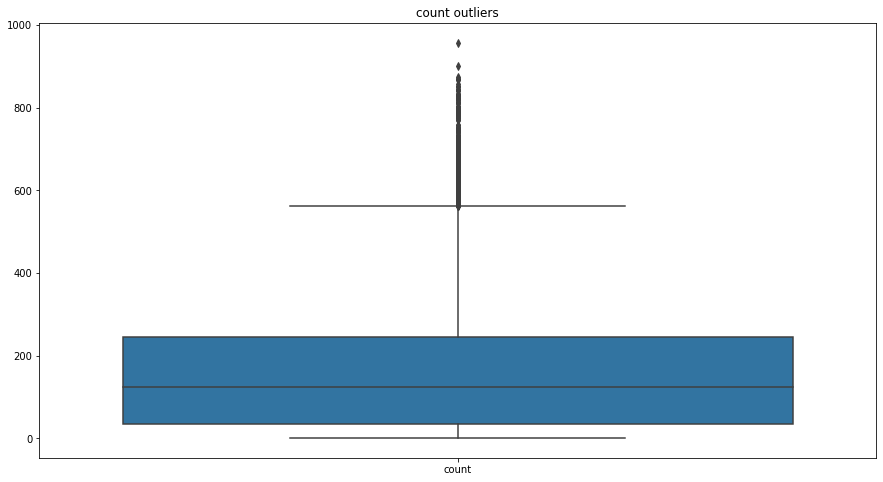

In [48]:
fig,ax=plt.subplots(figsize=(15,8))
#Boxplot for count outliers
sns.boxplot(data=train[['count']])
ax.set_title('count outliers')
plt.show()

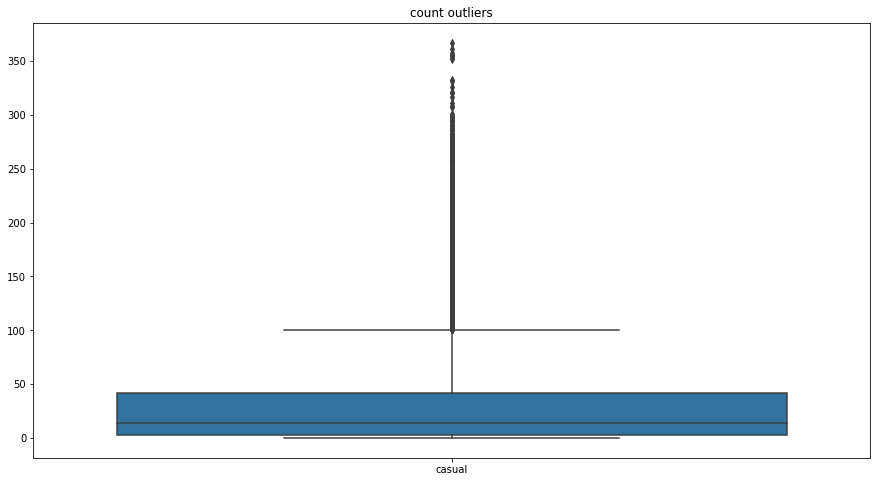

In [49]:
fig,ax=plt.subplots(figsize=(15,8))
#Boxplot for count outliers
sns.boxplot(data=train[['casual']])
ax.set_title('count outliers')
plt.show()

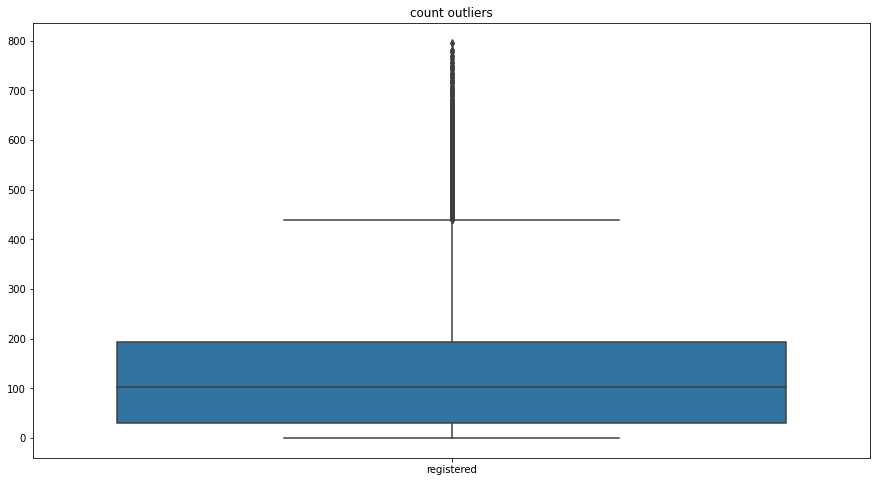

In [50]:
fig,ax=plt.subplots(figsize=(15,8))
#Boxplot for count outliers
sns.boxplot(data=train[['registered']])
ax.set_title('count outliers')
plt.show()

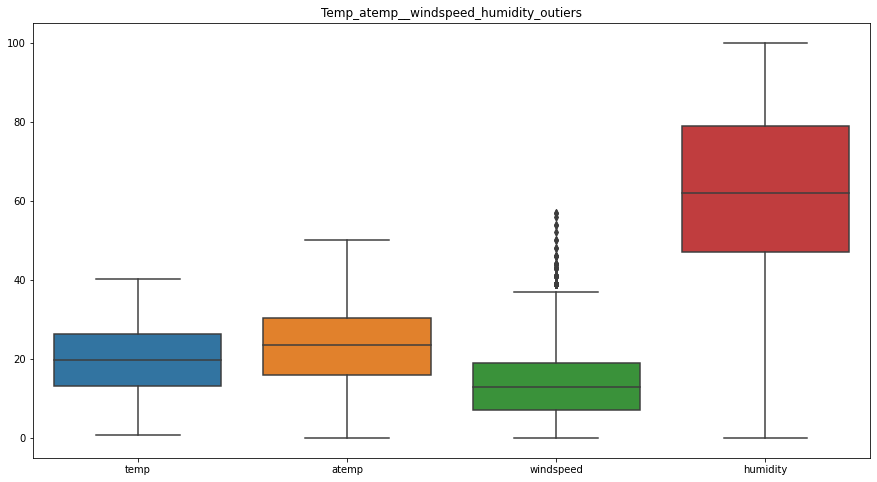

In [51]:
fig,ax=plt.subplots(figsize=(15,8))
#Box plot for temp_atemp_windspeed_humidity_outliers
sns.boxplot(data=train[['temp','atemp','windspeed','humidity']])
ax.set_title('Temp_atemp__windspeed_humidity_outiers')
plt.show()

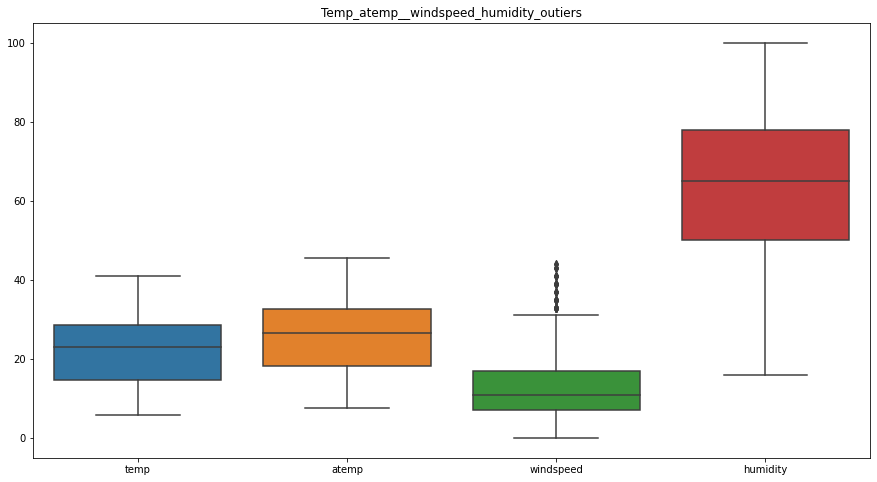

In [52]:
fig,ax=plt.subplots(figsize=(15,8))
#Box plot for temp_atemp_windspeed_humidity_outliers
sns.boxplot(data=test[['temp','atemp','windspeed','humidity']])
ax.set_title('Temp_atemp__windspeed_humidity_outiers')
plt.show()

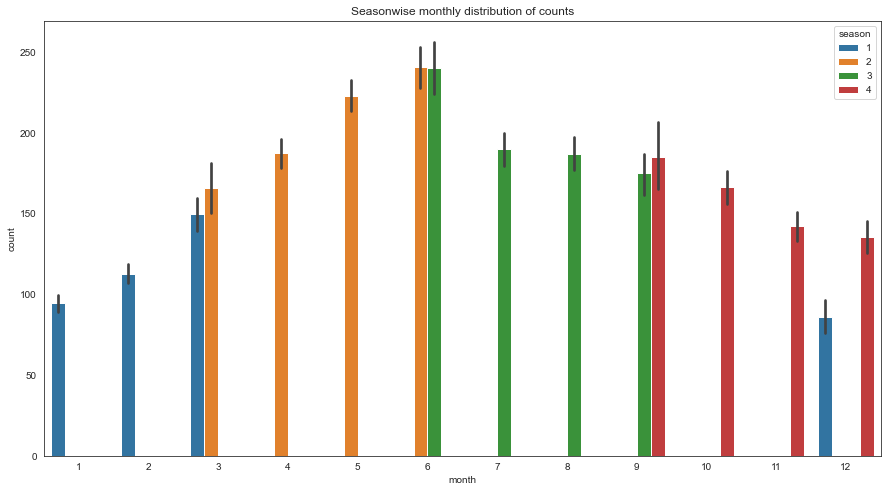

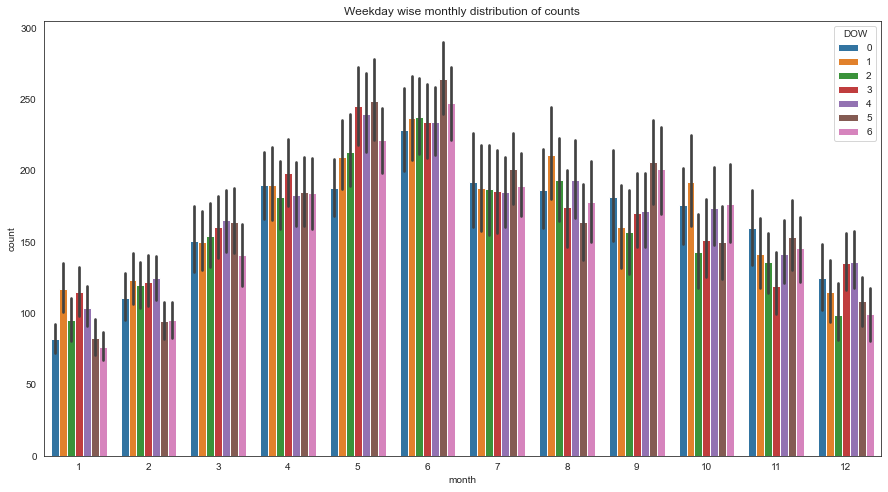

In [72]:
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='month',y='count',data=train[['month','count','season']],hue='season',ax=ax)
ax.set_title('Seasonwise monthly distribution of counts')
plt.show()
#Bar plot for weekday wise monthly distribution of counts
fig,ax1=plt.subplots(figsize=(15,8))
sns.barplot(x='month',y='count',data=train[['month','count','DOW']],hue='DOW',ax=ax1)
ax1.set_title('Weekday wise monthly distribution of counts')
plt.show()

## Univariate Analysis

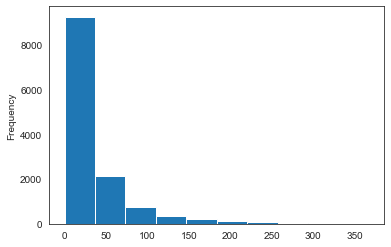

In [83]:
train['casual'].plot.hist()

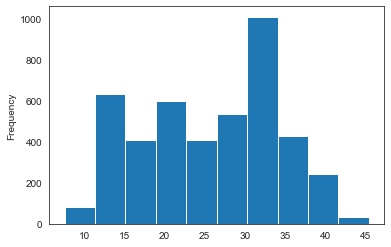

In [77]:
test['atemp'].plot.hist()

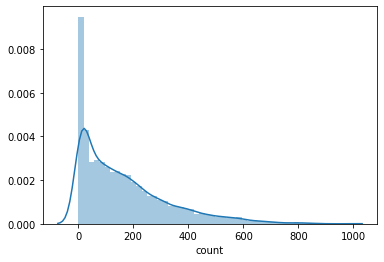

In [67]:
# distribution of count variable
sns.distplot(train["count"])

The distribution is skewed towards right and hence we can take log of the variable and see if the distribution becomes normal.

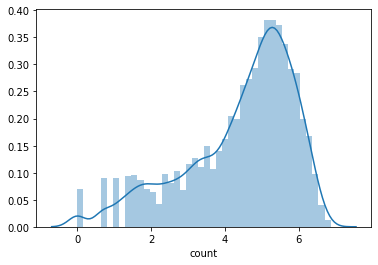

In [68]:
sns.distplot(np.log(train["count"]))

Now the distribution looks less skewed. Let's now explore the variables to have a better understanding of the dataset. We will first explore the variables individually using univariate analysis, then we will look at the relation between various independent variables and the target variable. We will also look at the correlation plot to see which variables affects the target variable most.

Let's first look at the distribution of registered variable to check the number of registered user rentals initiated.

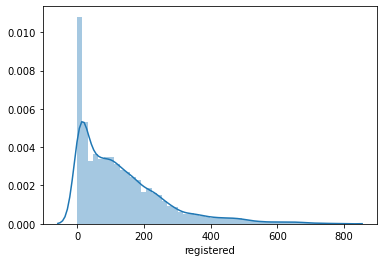

In [70]:
sns.distplot(train["registered"])

We can see that most of the registered rentals lies in the range of 0 to 200. The registered users at a particular time step will always be less than or equal to the demand (count) of that particular timestep. 

Let's now look at how correlated our numerical variables are. 

We will see the correlation between each of these variables and the variable which have high negative or positive values are correlated. By this we can get an overview of the variables which might affect our target variable.

## Bivariate Analysis

In [ ]:
# looking at the correlation between numerical variables
corr = train[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corr, mask=mask,vmax=.9, square=True,annot=True, cmap="YlGnBu")

Some of the inferences from the above correlation map are:

1. temp and humidity features has got positive and negative correlation with count respectively.Although the correlation between them are not very prominent still the count variable has got little dependency on "temp" and "humidity".

2. windspeed will not be really useful numerical feature and it is visible from it correlation value with "count"

3. Since "atemp" and "temp" has got strong correlation with each other, during model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.

Before building the model, let's check if there are any missing values in the dataset.

In [ ]:
# looking for missing values in the datasaet
train.isnull().sum()

There are no missing values in the train dataset. Let's look for the missing values in the test dataset.

In [ ]:
test.isnull().sum()

There are no missing values in the test dataset as well. We can now move further and build our first model. Before that let's first extract some new features using the datetime variable. We can extract the date, hour, month.

In [ ]:
# extracting date, hour and month from the datetime
train["date"] = train.datetime.apply(lambda x : x.split()[0])
train["hour"] = train.datetime.apply(lambda x : x.split()[1].split(":")[0])
train["month"] = train.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

You can also use to_datetime() function from pandas package to convert the date in datetime format and then extract features from it. 

Let's now build a linear regression model to get the predictions on the test data. We have to make the similar changes in test data as we have done for the training data.

In [ ]:
test["date"] = test.datetime.apply(lambda x : x.split()[0])
test["hour"] = test.datetime.apply(lambda x : x.split()[1].split(":")[0])
test["month"] = test.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

Now our data is ready. Before making the model, we will create a validation set to validate our model. So, we will divide the train set into training and validation set. We will train the model on the training set and check its performance on the validation set. Since the data is time based, we will split it as per time. Let's take first 15 months for training and remaining 3 months in the validation set. 

In [ ]:
training = train[train['datetime']<='2012-03-30 0:00:00']
validation = train[train['datetime']>'2012-03-30 0:00:00']

* We will drop the datetime, date variable as we have already extracted features from these variables.
* We will also drop the atemp variable as we saw that it is highly correlated with the temp variable.

In [ ]:
train = train.drop(['datetime','date', 'atemp'],axis=1)
test = test.drop(['datetime','date', 'atemp'], axis=1)
training = training.drop(['datetime','date', 'atemp'],axis=1)
validation = validation.drop(['datetime','date', 'atemp'],axis=1)

## Model Building
### Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# initialize the linear regression model
lModel = LinearRegression()

We will remove the target variable from both the training and validation set and keep it in a separate variable. We saw in the visualization part that the target variable is right skewed, so we will take its log as well before feeding it to the model.

In [ ]:
X_train = training.drop('count', 1)
y_train = np.log(training['count'])
X_val = validation.drop('count', 1)
y_val = np.log(validation['count'])

In [ ]:
# checking the shape of X_train, y_train, X_val and y_val
X_train.shape, y_train.shape, X_val.shape, y_val.shape

In [ ]:
# fitting the model on X_train and y_train
lModel.fit(X_train,y_train)

Now we have a trained linear regression model with us. We will now make prediction on the X_val set and check the performance of our model. Since the evaluation metric for this problem is RMSLE, we will define a model which will return the RMSLE score.

In [ ]:
# making prediction on validation set
prediction = lModel.predict(X_val)

In [ ]:
# defining a function which will return the rmsle score
def rmsle(y, y_):
    y = np.exp(y),   # taking the exponential as we took the log of target variable
    y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

Let's now calculate the rmsle value of the predictions

In [ ]:
rmsle(y_val,prediction)

In [ ]:
# uncomment it to save the predictions from linear regression model and submit these predictions to generate score.
# test_prediction = lModel.predict(test)

We got a rmsle value of 0.8875 on the validation set.

Let's use Decision Tree now. Note that rmsle tells us how far the predictions are from the actual value, so we want rmsle value to be as close to 0 as possible. So, we will further try to reduce this value.

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# defining a decision tree model with a depth of 5. You can further tune the hyperparameters to improve the score
dt_reg = DecisionTreeRegressor(max_depth=5)

Let's fit the decision tree model now.

In [ ]:
dt_reg.fit(X_train, y_train)

Its time to make prediction on the validation set using the trained decision tree model.

In [ ]:
predict = dt_reg.predict(X_val)

In [ ]:
# calculating rmsle of the predicted values
rmsle(y_val, predict)

The rmsle value has decreased to 0.171. This is a decent score. Let's now make predictions for the test dataset which you can submit in the excel sheet provided to you to generate your score.

In [ ]:
test_prediction = dt_reg.predict(test)

These are the log values and we have to convert them back to the original scale. 

In [ ]:
final_prediction = np.exp(test_prediction)

Finally, we will save these predictions into a csv file. You can then open this csv file and copy paste the predictions on the provided excel file to generate score.

In [ ]:
submission = pd.DataFrame()

In [ ]:
# creating a count column and saving the predictions in it
submission['count'] = final_prediction

In [ ]:
submission.to_csv('submission.csv', header=True, index=False)

Now you have the submission file with you. Follow these steps to generate your score:
1. Open the submission.csv file.
2. Copy the values in the count column and paste them in the count column of solution_checker.xlsx file.
3. You will see the rmsle score of the model on test dataset under Your score column.